<a href="https://colab.research.google.com/github/varshika15/Histopathological-Image-Classification/blob/main/BreastCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
#!pip install tensorflow-gpu==1.14
#!pip install keras==2.2.5
import os
os.chdir('/content/drive/My Drive/breast/')
from keras import layers

In [ ]:
benign_path = '/content/drive/My Drive/breast/benign/SOB/'
malignant_path = '/content/drive/My Drive/breast/malignant/SOB/'

In [ ]:
benign_terms = os.listdir(benign_path)
benign_files_path = []
for i in range(0, len(benign_terms)):
    x = benign_path + benign_terms[i] + '/'
    for j in range(0, len(os.listdir(x))):
        y = x + os.listdir(x)[j] + '/100X/'
        for k in range(0, len(os.listdir(y))):
            z = y + os.listdir(y)[k]
            benign_files_path.append(z)
len(benign_files_path)

646

In [ ]:
malignant_terms = os.listdir(malignant_path)
malignant_files_path = []
for i in range(0, len(malignant_terms)):
    x = malignant_path + malignant_terms[i] + '/'
    for j in range(0, len(os.listdir(x))):
        y = x + os.listdir(x)[j] + '/100X/'
        for k in range(0, len(os.listdir(y))):
            z = y + os.listdir(y)[k]
            malignant_files_path.append(z)
len(malignant_files_path)

1440

In [ ]:
print(len(benign_files_path), len(malignant_files_path))

646 1440


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot  as plt
from PIL import Image
from tqdm import tqdm

(460, 700, 3)

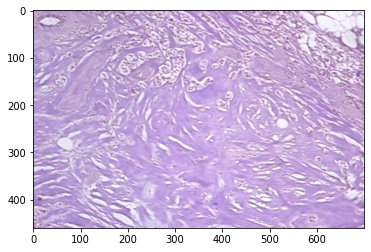

In [ ]:
im = cv2.imread('/content/drive/My Drive/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-010.png')
plt.imshow(im)
im.shape

In [ ]:
def Dataset_Loader(TYPE, RESIZE):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert('RGB'))
    for image_name in tqdm(TYPE):
        img = read(image_name)
        img = cv2.resize(img, (RESIZE, RESIZE))
        IMG.append(np.array(img))
    return IMG


In [ ]:
benign_data = Dataset_Loader(benign_files_path, 224)
malignant_data = Dataset_Loader(malignant_files_path, 224)

100%|██████████| 1440/1440 [10:20<00:00,  2.32it/s]


In [ ]:
from sklearn.model_selection import train_test_split
benign_train, benign_test = train_test_split(benign_data, test_size = 0.25)
malignant_train, malignant_test = train_test_split(malignant_data, test_size = 0.25)

In [ ]:
benign_train_label = np.zeros(len(benign_train))
malignant_train_label = np.ones(len(malignant_train))
benign_test_label = np.zeros(len(benign_test))
malignant_test_label = np.ones(len(malignant_test))

In [ ]:
X_train = np.concatenate((benign_train, malignant_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malignant_train_label), axis = 0)
X_test = np.concatenate((benign_test, malignant_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malignant_test_label), axis = 0)

In [ ]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
from keras.utils.np_utils import to_categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

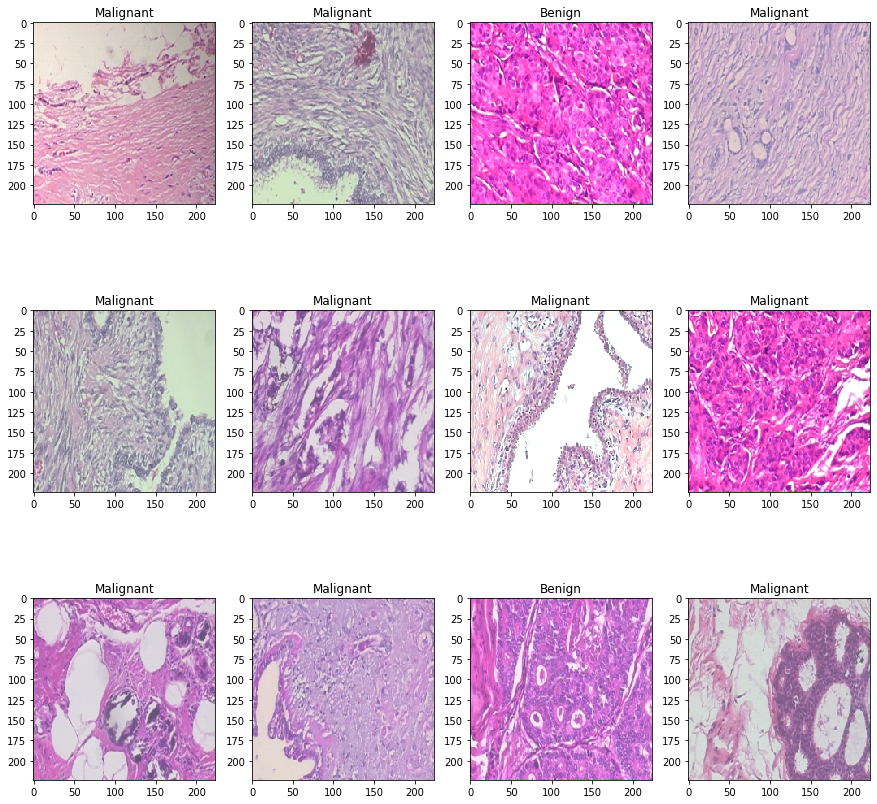

(224, 224, 3)

In [ ]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()
x_train[0].shape

In [ ]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model


In [ ]:
from keras import backend as K
import gc
K.clear_session()
gc.collect()

densenet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

resnet =  InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
 


model1 = build_model(resnet ,lr = 1e-4)
model2 =build_model(densenet, lr = 1e-4)
model1.summary()
model2.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
batch_normalization_204 (Bat (None, 1536)              6144      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3074      
Total params: 54,345,954
Trainable params: 54,282,338
Non-trainable params: 63,616
_________________________________________________________________
Model: "sequential_2"
________________

In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/cancer_weights_best_resnet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history1 = model1.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/30
79/78 [==============================] - 101s 1s/step - loss: 0.8454 - accuracy: 0.6347 - val_loss: 0.7314 - val_accuracy: 0.6837
Epoch 2/30


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


79/78 [==============================] - 33s 417ms/step - loss: 0.5699 - accuracy: 0.7794 - val_loss: 0.3806 - val_accuracy: 0.8658
Epoch 3/30
79/78 [==============================] - 33s 424ms/step - loss: 0.4620 - accuracy: 0.8305 - val_loss: 0.5265 - val_accuracy: 0.7476
Epoch 4/30
79/78 [==============================] - 33s 416ms/step - loss: 0.4132 - accuracy: 0.8513 - val_loss: 0.4032 - val_accuracy: 0.9233
Epoch 5/30
79/78 [==============================] - 33s 419ms/step - loss: 0.4437 - accuracy: 0.8377 - val_loss: 0.5956 - val_accuracy: 0.7636
Epoch 6/30
79/78 [==============================] - 33s 418ms/step - loss: 0.3549 - accuracy: 0.8721 - val_loss: 0.3845 - val_accuracy: 0.7796
Epoch 7/30
79/78 [==============================] - 33s 414ms/step - loss: 0.3582 - accuracy: 0.8721 - val_loss: 0.3452 - val_accuracy: 0.9201
Epoch 8/30
79/78 [==============================] - 33s 421ms/step - loss: 0.3049 - accuracy: 0.8857 - val_loss: 0.1992 - val_accuracy: 0.9137
Epoch 9/30

In [ ]:
history2 = model2.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/30
79/78 [==============================] - 130s 2s/step - loss: 0.6318 - accuracy: 0.7010 - val_loss: 0.4886 - val_accuracy: 0.7732
Epoch 2/30


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


79/78 [==============================] - 41s 517ms/step - loss: 0.4824 - accuracy: 0.7946 - val_loss: 0.3757 - val_accuracy: 0.8594
Epoch 3/30
79/78 [==============================] - 41s 516ms/step - loss: 0.3793 - accuracy: 0.8521 - val_loss: 0.2223 - val_accuracy: 0.9233
Epoch 4/30
79/78 [==============================] - 41s 514ms/step - loss: 0.3466 - accuracy: 0.8521 - val_loss: 0.2992 - val_accuracy: 0.8946
Epoch 5/30
79/78 [==============================] - 41s 516ms/step - loss: 0.3173 - accuracy: 0.8769 - val_loss: 0.1270 - val_accuracy: 0.9425
Epoch 6/30
79/78 [==============================] - 41s 514ms/step - loss: 0.2844 - accuracy: 0.8849 - val_loss: 0.1936 - val_accuracy: 0.9137
Epoch 7/30
79/78 [==============================] - 41s 519ms/step - loss: 0.2589 - accuracy: 0.8961 - val_loss: 0.2042 - val_accuracy: 0.9489
Epoch 8/30
79/78 [==============================] - 41s 519ms/step - loss: 0.2880 - accuracy: 0.8865 - val_loss: 0.4429 - val_accuracy: 0.8722
Epoch 9/30

In [ ]:
from sklearn.ensemble import VotingClassifier 

In [ ]:
import json
with open('/content/drive/My Drive/history.json', 'w') as f:
    json.dump(str(history.history), f)

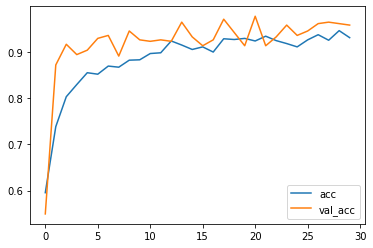

In [ ]:
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df[['acc', 'val_acc']].plot() 

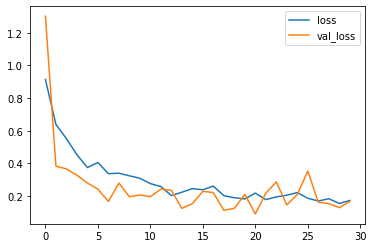

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [ ]:
model.load_weights("/content/drive/My Drive/cancer_weights_best.hdf5")
Y_val_pred = model.predict(x_val)

In [ ]:
from sklearn.metrics import cohen_kappa_score, accuracy_score
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9776357827476039

In [ ]:

Y_pred = model.predict(X_test)

In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████| 10/10 [01:15<00:00,  7.56s/it]


Confusion matrix, without normalization
[[154   8]
 [  4 356]]


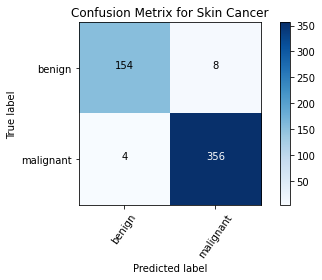

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')


Shallow Model

In [ ]:
def shallow_model( lr=1e-3):
    model = Sequential()
    model.add(layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size= (2,2)))
    model.add(layers.Conv2D(64, 3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size= (2,2)))
    model.add(layers.Dense(1280, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))


    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model


In [ ]:
from keras import backend as K
import gc
K.clear_session()
gc.collect()



model = shallow_model(lr = 1e-3)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 54, 54, 1280)     

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

NameError: ignored